### 1. Load data

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.naive_bayes import MultinomialNB, ComplementNB # naive Bayes
from sklearn.linear_model import SGDClassifier # SVM
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [34]:
train_fpath = '/home/veera/LST_project/toy_data/train_data.csv'
test_fpath = '/home/veera/LST_project/toy_data/test_data.csv'
labels_col_name = 'Label'
id_col_name = 'id_str'

def download_from_csv(filename):
    # Helper for creating a matrix (ndarray) out of csv data
    df = pd.read_csv(filename, header=0, index_col=id_col_name)
    feature_names = np.asarray(df.columns.values) 
    features = df.drop(labels_col_name, axis=1).values
    labels = df[labels_col_name].values

    return features, labels, feature_names

X_train, y_train, feature_names = download_from_csv(train_fpath)
X_test, y_test, _ = download_from_csv(test_fpath)

print(X_train.shape, X_test.shape)
print(feature_names)

(146, 222) (49, 222)
['action' 'air' 'air pollution' 'also' 'amount' 'amp' 'anti' 'april'
 'around' 'back' 'bad' 'barackobama' 'become' 'big' 'bin' 'biodiversity'
 'building' 'business' 'call' 'cant' 'car' 'carbon' 'cause' 'change'
 'change denier' 'child' 'city' 'clear' 'climate' 'climate change'
 'climatechange' 'close' 'co' 'consequence' 'construction' 'continue'
 'control' 'coronavirus' 'coronavirus covid' 'could' 'covid' 'create'
 'crisis' 'cut' 'day' 'deal' 'death' 'denial' 'denier' 'deniers' 'didnt'
 'die' 'distance' 'doesnt' 'dont' 'drive' 'due' 'earth' 'economy' 'else'
 'emergency' 'emission' 'emission standard' 'energy' 'environment' 'epa'
 'especially' 'even' 'every' 'fall' 'far' 'find' 'first' 'food' 'fossil'
 'fossil fuel' 'fuel' 'garden' 'gas' 'get' 'give' 'global' 'global warm'
 'go' 'good' 'good thing' 'google' 'government' 'great' 'green' 'grow'
 'guy' 'health' 'help' 'hes' 'hey' 'high' 'hoax' 'human' 'im' 'impact'
 'important' 'improve' 'increase' 'international' 'ive

### 2. Explorative data analysis

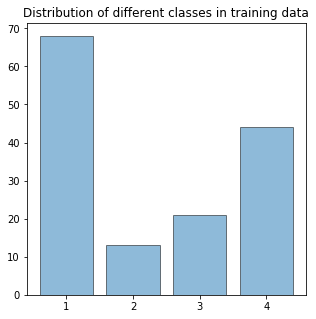

In [3]:
# visualize class distribution
fig1, ax = plt.subplots(1, 1, figsize=(5, 5))
hist = ax.hist(y_train, bins=np.arange(0.5, 5.5, 1), alpha=0.5, ec='black', rwidth=0.8)
ax.xaxis.set_ticks([i for i in range(1, 5)])
ax.set_title('Distribution of different classes in training data')

plt.show()

### 3. Fit model 

In [40]:
# Unbalanced class weights

#classifier = ComplementNB()
classifier = SGDClassifier()

classifier.fit(X_train, y_train)

# Balanced class weights

classifier_balanced = SGDClassifier(class_weight='balanced')

classifier_balanced.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

### 4. Validate

In [41]:
# Prediction accuracy score for testing data
print("Score (unbalanced classes): %0.2f" % classifier.score(X_test, y_test))

# Cross-validation
X = np.vstack((X_train, X_test))
y = np.hstack((y_train, y_test))
cv_scores = cross_val_score(classifier, X, y)
print("Cross-validation accuracy (unbalanced classes): %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

# Same for balanced classes
print("Score (balanced classes): %0.2f" % classifier_balanced.score(X_test, y_test))

# Cross-validation
X = np.vstack((X_train, X_test))
y = np.hstack((y_train, y_test))
cv_scores = cross_val_score(classifier_balanced, X, y)
print("Cross-validation accuracy (balanced classes): %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

Score (unbalanced classes): 0.59
Cross-validation accuracy (unbalanced classes): 0.48 (+/- 0.05)
Score (balanced classes): 0.47
Cross-validation accuracy (balanced classes): 0.50 (+/- 0.08)


In [42]:
# Confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

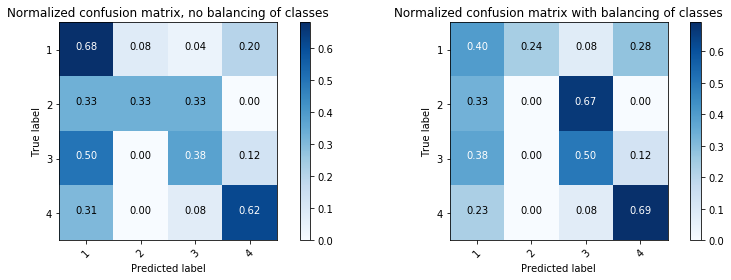

In [43]:
# Compute confusion matrix
class_labels = [str(i+1) for i in range(4)]
y_pred = classifier.predict(X_test)
y_pred_balanced = classifier_balanced.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix_balanced = confusion_matrix(y_test, y_pred_balanced)
np.set_printoptions(precision=2)

# Plot normalized confusion matrices
plt.figure(figsize=(12, 4))
plt.subplot(121) 
plot_confusion_matrix(cnf_matrix, classes=class_labels, normalize=True,
                      title='Normalized confusion matrix, no balancing of classes')
plt.subplot(122) 
plot_confusion_matrix(cnf_matrix_balanced, classes=class_labels, normalize=True,
                      title='Normalized confusion matrix with balancing of classes')

In [44]:
print("Top 10 keywords per class:")
for i in range(4):
    top10 = np.argsort(classifier.coef_[i])[-10:]
    print("%s: %s" % (i+1, ", ".join(feature_names[top10])))

Top 10 keywords per class:
1: health, earth, land, death, die, kill, big, green, create, coronavirus
2: usually, still, hoax, un, carbon, pollution, barackobama, increase, guy, way
3: part, distance, co, city, action, really, rule, also, lead, think
4: pollution, lot, could, anti, drive, food, work, get, bad, recycle
